In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [3]:
class_names = ["EMCI","LMCI","MCI","AD","CN"]
class_index=[0,1,2,3,4]

In [4]:
path=r"G:\dataset\Alzheimers-ADNI"

In [5]:
import pickle
fileOpen = open(path+'/data',"rb")
data = pickle.load(fileOpen)
fileOpen.close()

trainData=data['X']
trainDataLables=data['y']
print(trainData.shape,trainDataLables.shape)
flatTrainData=[]
for i in trainData:
    flatTrainData.append(i.flatten())
flatTrainData=np.array(flatTrainData)

(2430, 128, 128) (2430,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(flatTrainData,
                                                    trainDataLables,
                                                    test_size=.25,
                                                    random_state=1234123)

In [7]:
model = RandomForestClassifier(max_depth=20, random_state=0)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, random_state=0)

In [8]:
y_pred = model.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.743421052631579


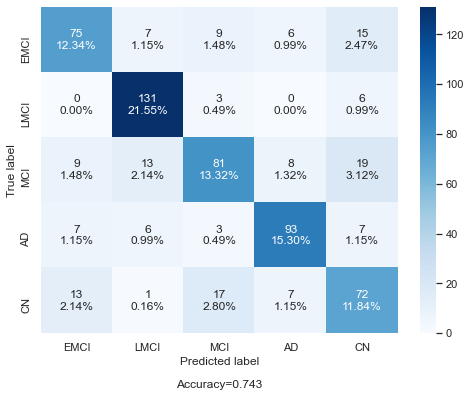

In [9]:
sns.set()
cf_matrix=confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix,categories=class_names,cmap='Blues',figsize=(8,6))

In [10]:
from sklearn.model_selection import cross_val_score
score=cross_val_score(model,X_train, y_train,cv=10)

In [11]:
score

array([0.72131148, 0.71038251, 0.74175824, 0.72527473, 0.68131868,
       0.65384615, 0.67032967, 0.67582418, 0.73076923, 0.7032967 ])

In [12]:
arr=[0.71584699, 0.72677596, 0.64285714, 0.67582418, 0.72527473,
       0.69230769, 0.78571429, 0.69230769, 0.71978022, 0.64285714]
arr=np.array(arr)
print(np.average(arr))
print(np.average(np.array(score)))

0.701954603
0.7014111571488622
